# Style-aware generation of text

In [0]:
# function ClickConnect(){
#     console.log("Working");
#     document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
# }
# setInterval(ClickConnect, 30000)

In [1]:
# Mount Google Drive and go to correct directory
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [11]:
# Navigate to the correct directory
%cd drive/"My Drive"/"Colab Notebooks"/master_project

/content/drive/My Drive/Colab Notebooks/master_project


In [12]:
import pickle
import tqdm
import time
import itertools
import math
import numpy as np
import keras
from keras.layers import Layer, Embedding, Input, Concatenate, Bidirectional, LSTM, TimeDistributed, Dense, Dropout, Lambda
from keras.models import Model
from keras import initializers, constraints, regularizers
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
from operator import itemgetter
from IPython.display import HTML, display
from timeit import default_timer as timer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction import stop_words

from utilities import *
from get_antonyms import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
!ls

drive  sample_data


## Data

In [0]:
# Load fully pre-preprocessed test data
with open("HAN/fully_processed.pickle", "rb") as handle:
    *_, x_test, y_test, pos_test, is_set, word_index, pos_index= pickle.load(handle)

## Model


In [0]:
# Attention Layer
# Adapted from https://gist.github.com/cbaziotis/7ef97ccf71cbc14366835198c09809d2
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatibl|e with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [0]:
max_senten_len = 100
embed_size = 300
max_senten_num = 1

In [0]:
embedding_name = "SKIP_negative10_EN_Change_inputSentiment_weightsum.p"

In [0]:
# Load word embedding matrix
embedding_name = embedding_name.split(".")[0]
with open("HAN/"+embedding_name+"_embedding_matrix.pickle", "rb") as handle:
    embedding_matrix = pickle.load(handle)

In [0]:
# Load POS-tag embedding matrix
pos_set = {'X', 'INTJ', 'PUNCT', 'PART', 'NUM', 'ADP', 'PROPN', 'ADV', 'SYM', 'ADJ', 'VERB', 'DET', 'PRON', 'AUX', 'CCONJ', 'NOUN'}
with open("HAN/pos_embedding_matrix.pickle", "rb") as handle:
    pos_embedding_matrix = pickle.load(handle)

In [0]:
embedding_layer = Embedding(len(word_index) + 1, embed_size, weights=[embedding_matrix], input_length=max_senten_len, trainable=False)

In [0]:
embedding_pos = Embedding(len(word_index) + 1, len(pos_set), input_length=max_senten_len, trainable=False)

In [0]:
# Regularization to reduce overfitting
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [0]:
# Individual parts of the model

# Combined input has the shape => number of inputs * MAX_SENT_LENGTH
# NOTE: The seperation of individual inputs only works when num_inputs = 2, use different seperation method if more inputs are used
num_inputs = 2 
combined_input = Input(shape=(num_inputs*max_senten_len,), dtype='float32')
# Seperate word input
word_input = Lambda(lambda x: x[:, 0:max_senten_len])(combined_input)
# Get the word-embeddings
word_sequences = embedding_layer(word_input)
# Seperate the POS input
pos_input = Lambda(lambda x: x[:, max_senten_len: ])(combined_input)
pos_shaped = embedding_pos(pos_input)
# Concatenate the word embeddings with our POS-vectors
merged = Concatenate()([word_sequences, pos_shaped])

word_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(merged)
word_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(word_lstm)
word_att = AttentionWithContext()(word_dense)
wordEncoder = Model(inputs=combined_input, outputs=word_att)

sent_input = Input(shape=(max_senten_num, num_inputs*max_senten_len), dtype='float32')
sent_encoder = TimeDistributed(wordEncoder)(sent_input)
sent_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(sent_encoder)
sent_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(sent_lstm)
sent_att = Dropout(0.5)(AttentionWithContext()(sent_dense))
preds = Dense(len(set(y_test)), activation='softmax')(sent_att)
model = Model(sent_input, preds)

model.compile(loss='categorical_crossentropy',optimizer=Adam(0.1, amsgrad=True),metrics=['acc'])

## Locate sentiment words

In [0]:
# Combine word and POS input
test_input = np.c_[x_test, pos_test]

In [24]:
tqdm.tnrange(5) # tqdm.notebook gives error without first trying tqdm normally

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """Entry point for launching an IPython kernel.


  0%|<bar/>| 0/5 [00:00<?, ?it/s]

In [0]:
model.load_weights("HAN/models/model1/han_trained_weights")

In [0]:
def get_attention_weights(data_input, data_sentence, threshold=1): # len(test_input)
    '''
    Get the attention_weights for the words in one or more sentences
    '''
    for i, q in zip(tqdm.notebook.tnrange(threshold), range(threshold)):  
        get_layer_output = K.function([model.layers[0].input, K.learning_phase()], [model.layers[3].output])
        out = get_layer_output([data_input[q],0])  
        eij = np.tanh(np.dot(out[0],model.layers[4].get_weights()[0]))
        t = np.dot(eij,model.layers[4].get_weights()[2])
        ai = np.exp(t)
        weights = ai/np.sum(ai)
        get_layer_op_words = K.function([wordEncoder.layers[0].input, K.learning_phase()], [wordEncoder.layers[7].output])
        op_words = get_layer_op_words([data_input[q],0])

        weight_all_words = []
        for i in range(max_senten_num):
            eij_words = np.tanh(np.dot(op_words[0][i], wordEncoder.layers[8].get_weights()[0]))
            t_words = np.dot(eij_words,wordEncoder.layers[8].get_weights()[2])
            ai_words = np.exp(t_words)
            weights_words = ai_words/np.sum(ai_words)
            weight_all_words.append(weights_words)

        id2word = {v: k for k, v in word_index.items()}    
        sent_number = 0
        sentence = []
        sentence_at = np.zeros(np.count_nonzero(data_sentence[q][0])) # since there is only one sentence we can extract its length
        for i in data_sentence[q]:
            weights_words = weight_all_words[sent_number]
            word_no = 0
            for j in i:
                if j!=0:
                    word = id2word[j]  
                    sentence.append(word)
                    sentence_at[word_no] = weights_words[word_no] # attention weight of word
                    # print(word, weights_words[word_no], sep="\t\t")            
                word_no+=1
            sent_number+=1
        assert len(sentence) == len(sentence_at)
        yield sentence, sentence_at
        #print(*zip(sentence, softmax(sentence_at)), sep="\n", end="\n\n")

In [0]:
# # Check if always same attention weights (if so model weights loaded succesfully)
# for i, j in get_attention_weights(test_input, x_test, threshold=2):
#     print(softmax(j))

In [0]:
try:
    with open("sentence_attention_dict.pickle", "rb") as handle:
       sentence_attention_dict = pickle.load(handle)
except FileNotFoundError as e:
    sentence_attention_dict = {}

In [0]:
with open("HAN/df_all.pkl", "rb") as handle:
    df_all = pickle.load(handle)
test_sentences = df_all.words[df_all.is_which_set == "test"]

In [0]:
# Get the attention weights for all words of the test set
first = True
while len(sentence_attention_dict) < len(set(test_sentences)):
    start = timer()
    if not first:
        print("\nOpening File...")
        with open("sentence_attention_dict.pickle", "rb") as handle:
            sentence_attention_dict = pickle.load(handle)
    print(f"Start attention search... {len(sentence_attention_dict)}/{len(test_input)}")
    remaining = len(sentence_attention_dict)  
    sent_att_gen = get_attention_weights(data_input=test_input[remaining:], data_sentence=x_test[remaining:], threshold=len(x_test[remaining:]))
    for idx, (sentence, attention) in enumerate(sent_att_gen):
        try:
            sentence_attention_dict[" ".join(sentence)]
            print("Already in dict")
        except KeyError as e:
            sentence_attention_dict[" ".join(sentence)] = attention
        if idx == 2500:
            first = False
            break
    print("Saving File...")
    with open("sentence_attention_dict.pickle", "wb") as handle:
        pickle.dump(sentence_attention_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    time.sleep(5)
    print(f"Minutes: {round((timer() - start)/60, 2)}")

In [0]:
# see directory pickles-5-5-2020
# def decide_subtitutes(sentence, attention, normalization="softmax", threshold=0.85):
#     '''
#     Decide which words need to be substituted
#     '''
#     if normalization == "softmax":
#         attention = softmax(attention)

#     try:
#         pos_tags = df_all.pos[df_all.words == sentence].item().split()
#     except ValueError as e:
#         pos_tags = df_all.pos[df_all.words == sentence].tolist()[0].split()

#     sentence = sentence.split()
#     substitute_ids = []
#     for idx, (word, tag, score) in enumerate(zip(sentence, pos_tags, attention)):
#         # {'X', 'INTJ', 'PUNCT', 'PART', 'NUM', 'ADP', 'PROPN', 'ADV', 'SYM', 'ADJ', 'VERB', 'DET', 'PRON', 'AUX', 'CCONJ', 'NOUN'}
#         if len(word) > 2 and score >= threshold and tag not in ["NOUN", "DET", "PUNCT", "NUM", "PROPN", "CCONJ"]:
#             substitute_ids.append((idx, score))

#     if substitute_ids == []:
#         for idx, (word, tag, score) in enumerate(zip(sentence, pos_tags, attention)):
#             if len(word) > 2 and tag == "ADJ" and score >= 0.35:
#                 substitute_ids.append((idx, score))

#     if substitute_ids == []:
#         for idx, (word, tag, score) in enumerate(zip(sentence, pos_tags, attention)):
#             if len(word) > 2 and (tag == "ADV" or tag == "VERB"):
#                 substitute_ids.append((idx, score))
#         if len(substitute_ids) > 2:
#             substitute_ids = sorted(substitute_ids, key=itemgetter(1), reverse=True)
#             if substitute_ids[1][0] >= 0.7:
#                 substitute_ids = substitute_ids[:2]
#             else:
#                 substitute_ids = substitute_ids[0]

#     if substitute_ids == []:
#         for idx, word in enumerate(sentence):
#             if word == "not":
#                 substitute_ids.append((idx, 0))
#             break

#     return substitute_ids

In [0]:
def decide_subtitutes(sentence, attention, normalization="softmax", threshold=0.7):
    '''
    Decide which words need to be substituted
    '''
    if normalization == "softmax":
        attention = softmax(attention)

    try:
        pos_tags = df_all.pos[df_all.words == sentence].item().split()
    except ValueError as e:
        pos_tags = df_all.pos[df_all.words == sentence].tolist()[0].split()

    sentence = sentence.split()
    substitute_ids = []
    for idx, (word, tag, score) in enumerate(zip(sentence, pos_tags, attention)):
        # {'X', 'INTJ', 'PUNCT', 'PART', 'NUM', 'ADP', 'PROPN', 'ADV', 'SYM', 'ADJ', 'VERB', 'DET', 'PRON', 'AUX', 'CCONJ', 'NOUN'}
        # see directory pickles-5-5-2020
        # if len(word) > 2 and tag not in ["NOUN", "DET", "PUNCT", "NUM", "PROPN"]:
        #     substitute_ids.append((idx, score))

        if len(word) > 2 and tag not in ["NOUN", "DET", "PUNCT", "NUM", "PROPN", "CCONJ", "X"]:
            substitute_ids.append((idx, score))

    if len(substitute_ids) > 1:
        substitute_ids = sorted(substitute_ids,key=itemgetter(1), reverse=True)
        substitute_ids = [substitute_ids[0]] + [(id, score) for id, score in substitute_ids[1:] if score >= threshold]

    return substitute_ids

In [0]:
with open("sentence_attention_dict.pickle", "rb") as handle:
    sentence_attention_dict = pickle.load(handle)

try:
    with open("to_substitute_dict.pickle", "rb") as handle:
        to_substitute_dict = pickle.load(handle)
except FileNotFoundError as e:
    to_substitute_dict = {}
    with open("to_substitute_dict.pickle", "wb") as handle:
        pickle.dump(to_substitute_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

if len(sentence_attention_dict) != len(to_substitute_dict):
    for idx, (k, v) in enumerate(tqdm.tqdm(sentence_attention_dict.items())):
        try:
            to_substitute_dict[k]
        except KeyError as e:
            to_substitute_dict[k] = decide_subtitutes(k, v)
        if idx+1 in split_into_parts(len(sentence_attention_dict.items()), 4):
            with open("to_substitute_dict.pickle", "wb") as handle:
                pickle.dump(to_substitute_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Word Substitution


In [0]:
test_sentence1 = "it is very dense solid tastes like dark chocolate but its heaviness does not leave a good taste in your mouth"
print(softmax(sentence_attention_dict[test_sentence1]))
print("\n",to_substitute_dict[test_sentence1])
for idx, att in to_substitute_dict[test_sentence1]:
    print(test_sentence1.split()[idx])

[0.664 0.047 0.2   0.987 0.883 0.686 0.164 0.169 0.652 0.484 0.521 0.433
 0.164 0.059 0.21  0.884 0.738 0.629 0.794 0.626 0.413]

 [(3, 0.987), (4, 0.883), (16, 0.738)]
dense
solid
good


In [0]:
with open("antonym_dict.pickle", "rb") as handle:
    antonym_dict = pickle.load(handle)
print(f"Currently {len(antonym_dict)} antonyms stored")

Currently 8854 antonyms stored


In [0]:
try:
    with open("sentence_generatedsentence_dict.pickle", "rb") as handle:
        sentence_generatedsentence_dict = pickle.load(handle)
except FileNotFoundError as e:
    sentence_generatedsentence_dict = {}
    with open("sentence_generatedsentence_dict.pickle", "wb") as handle:
        pickle.dump(sentence_generatedsentence_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
# Test if scraping TheSauri works fine
assert power_thesaurus("warm", inspect=True)  == ['cool', 'chill', 'unfriendly', 'cold', 'frigid', 'unenthusiastic', 'harsh', 'atrocious', 'hostile', 'dull']
assert thesaurus("warm", inspect=True) == ['calm', 'cold', 'cool', 'freezing', 'stormy', 'unhappy', 'violent']

['cool', 'chill', 'unfriendly', 'cold', 'frigid', 'unenthusiastic', 'harsh', 'atrocious', 'hostile', 'dull']
['calm', 'cold', 'cool', 'freezing', 'stormy', 'unhappy', 'violent']


In [0]:
while len(sentence_generatedsentence_dict) != len(to_substitute_dict):
    start = timer()
    print(f"\nStart generating sentences... {len(sentence_generatedsentence_dict)}/{len(to_substitute_dict)}")
    # Ensure items that are already generated are skipped, since Python 3.6+ dicts are ordered according to insertion order
    for idx, (sentence, substitute_ids) in enumerate(itertools.islice(to_substitute_dict.items(), len(sentence_generatedsentence_dict), None)):
        generated_sentence = sentence.split()
        if type(substitute_ids) == tuple:
            substitute_ids = [substitute_ids]
        if len(substitute_ids) > 1:
            for id, score in substitute_ids:
                to_replace = generated_sentence[id]
                if to_replace == "not":
                    generated_sentence[id] = ""
                else:
                    antonym = get_antonym(to_replace)
                    generated_sentence[id] = antonym
        elif len(substitute_ids) == 1:
            to_replace = generated_sentence[substitute_ids[0][0]]
            if to_replace == "not":
                generated_sentence[substitute_ids[0][0]] = ""
            else:
                antonym = get_antonym(to_replace)
                generated_sentence[substitute_ids[0][0]] = antonym
        else:
            generated_sentence = sentence.split()
        sentence_generatedsentence_dict[sentence] = " ".join(generated_sentence)
        if idx == 2500:
            break
    print("Saving File...")
    with open("sentence_generatedsentence_dict.pickle", "wb") as handle:
        pickle.dump(sentence_generatedsentence_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    time.sleep(5)
    print(f"Minutes: {round((timer() - start)/60, 2)}")


Start generating sentences... 65026/99839
Saving File...
Minutes: 15.61

Start generating sentences... 67527/99839
Saving File...
Minutes: 14.94

Start generating sentences... 70028/99839
Saving File...
Minutes: 14.51

Start generating sentences... 72529/99839
Saving File...
Minutes: 14.27

Start generating sentences... 75030/99839
Saving File...
Minutes: 14.38

Start generating sentences... 77531/99839
Saving File...
Minutes: 14.23

Start generating sentences... 80032/99839
Saving File...
Minutes: 14.36

Start generating sentences... 82533/99839
Saving File...
Minutes: 14.23

Start generating sentences... 85034/99839
Saving File...
Minutes: 14.54

Start generating sentences... 87535/99839
Saving File...
Minutes: 14.63

Start generating sentences... 90036/99839
Saving File...
Minutes: 14.4

Start generating sentences... 92537/99839
Saving File...
Minutes: 13.69

Start generating sentences... 95038/99839
Saving File...
Minutes: 14.31

Start generating sentences... 97539/99839
Saving Fi

In [0]:
print(len(sentence_generatedsentence_dict), len(to_substitute_dict))

99839 99839


In [0]:
# Evaluation DataFrame
# eval_df =
# OG_sentence | OG_sentiment | GENERATED_sentence | GENERATED_sentiment

## Visualization of attention weights


In [79]:
# Visualization of word attention
# model = loaded_model
cmap_sent = plt.cm.Oranges
cmap = plt.cm.Blues

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

sentence_language = 0
sentence_pos = 0

threshold = 100
pbar = display(progress(0, threshold), display_id=True)
with open("visualization.html", "w") as html_file:
    html_file.write('<!DOCTYPE html>\n')
    html_file.write('<html>\n')
    html_file.write('<body>\n')
    for q in range(len(test_input)):
        if q >= threshold:
            break   
        get_layer_output = K.function([model.layers[0].input, K.learning_phase()], [model.layers[3].output])
        out = get_layer_output([test_input[q],0])  
        eij = np.tanh(np.dot(out[0],model.layers[4].get_weights()[0]))
        t = np.dot(eij,model.layers[4].get_weights()[2])
        ai = np.exp(t)
        weights = ai/np.sum(ai)
        get_layer_op_words = K.function([wordEncoder.layers[0].input, K.learning_phase()], [wordEncoder.layers[7].output])
        op_words = get_layer_op_words([test_input[q],0])

        weight_all_words = []
        for i in range(max_senten_num):
            eij_words = np.tanh(np.dot(op_words[0][i], wordEncoder.layers[8].get_weights()[0]))
            t_words = np.dot(eij_words,wordEncoder.layers[8].get_weights()[2])
            ai_words = np.exp(t_words)
            weights_words = ai_words/np.sum(ai_words)
            weight_all_words.append(weights_words)

        id2word = {v: k for k, v in word_index.items()}    

        sent_no = 0
        languages = ["Language", "Pos"]
        html_file.write('<b>Review (%s)</b> <br>' % q)
        for i, lang in zip(x_test[q], languages):
            weights_words = weight_all_words[sent_no]
            template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
            sent_template = '{} <span class="barcode"; style="color: black; background-color: {}">{}</span>'
            sent = ''
            word_no = 0
            if lang == "Language":
                sentence_language += float(weights[0][sent_no])
            elif lang == "Pos":
                sentence_pos += float(weights[0][sent_no])
            sent_color = matplotlib.colors.rgb2hex(cmap_sent(float(weights[0][sent_no])*0.75)[:3])
            html_file.write(sent_template.format("Sentence (0)", sent_color, '&nbsp' + str(weights[0][sent_no]) + '&nbsp'))     
            summed_weights = 0
            np_color = []
            for j in i:
                if j!=0:
                    alpha = weights_words[word_no]
                    np_color.append(alpha)
                    summed_weights += alpha
                word_no+=1
            word_no = 0
            np_color = softmax(np.array(np_color)) # normalize between 0->1
            for j, color in zip(i, np_color):
                if j!= 0:
                    color = matplotlib.colors.rgb2hex(cmap(float(color)*0.9)[:3])
                    word = id2word[j]
                    html_file.write(template.format(color, '&nbsp' + word + '&nbsp'))
                    sent+=id2word[j]+' '+str(weights_words[word_no])+' ' 
                word_no+=1
            html_file.write('<br>')
            sent_no+=1
        html_file.write('<br>')
        pbar.update(progress(q, threshold))
    html_file.write('</body>\n')
    html_file.write('</html>\n')     

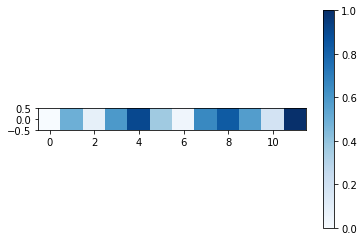

In [75]:
import numpy as np
import matplotlib.pyplot as plt
mat = np.array([[0,0.49508174, 0.08274638, 0.59135684, 0.90611644, 0.37030567, 0.04172206, 
                0.66000069, 0.83250818, 0.57374382, 0.18245247, 1]])
plt.imshow(mat, origin="lower", cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.show()